In [10]:
import pandas as pd 

In [11]:
df_triage = pd.read_csv('../triage/data/triage_initial_preprocessed.csv', sep=";", decimal=",")
df_harvard = pd.read_csv('../harvard/data/harvard_cleaned.csv', sep=";", decimal=",")

# print(df_harvard.columns)
print(df_triage.columns)

Index(['Gender, Male', 'Age', 'BMI', 'MMRC a', 'GOLD', 'Heartrate a',
       'Ox Saturation a', 'Worse Symptoms', '% Controller Taken',
       'Dyspnea details', 'Cough details', 'Wheezing details',
       'Sputum details', 'MMRC b', 'Infection', 'Night Symptoms',
       'Heartrate b', 'Ox Saturation b', '% FEV1 a', '% FEV1 b',
       'Current Temperature', 'Exacerbation', 'Height', 'Weight',
       'Congestive Heart Failure', 'Hypertension', 'ICU last year', 'Asthma',
       'Kidney disease', 'Anemia', 'Pulmonary Hypertension', 'Acid Reflux',
       'Smoker', 'Lives Alone', '2+ Exa. last year', 'Oxygen Therapy',
       'Help Daily Activities', 'Coronary Artery Disease',
       'Hospitalized last year', 'Diabetes', 'Pill to control Exa.',
       'Rescue Inhaler', 'Daily Inhaler'],
      dtype='object')


# Select Relevant Features

In [12]:
# TODO include medications and help with daily activities

relevant_vars_triage = [
    '2+ Exa. last year', # bclinpt22
    'Age', # dem02
    'Asthma', # bclinpt14
    'BMI', # bmi - from height (bclinra01)  and weight (bclinra02)
    'Congestive Heart Failure', # bclinpt07
    'Coronary Artery Disease', # blcinpt06
    'Cough details', # bclinpt30
    'Current Temperature', # could turn this into fever (bclinpt34)
    'Diabetes', # bclinpt15
    'Exacerbation', # fclinra08
    # 'FEV1', # bclinra202
    '% FEV1 a', # bclinra202c
    '% FEV1 b', # bclinra202c_2
    'Gender, Male', # dem03
    'GOLD', # bclinra11
    'Height', # bclinra01
    'Help Daily Activities', # An14
    'Hospitalized last year', # bclinpt24
    'Hypertension', # bclinpt04
    'ICU last year', # bclinpt26
    'Kidney disease', # bclinpt11
    'Lives Alone', # socio06
    'MMRC a', # mmrc
    'MMRC b', # mmrc
    'Night Symptoms', # psqidistb (sleep disturbance score)
    'Oxygen Therapy', # Oxygen_ra
    'Pill to control Exa.',
    'Daily Inhaler',
    'Rescue Inhaler',
    'Dyspnea details', #bclinpt28
    'Sputum details', # bclinpt32
    'Weight', # bclinra02
    'Wheezing details', # bclinpt38
    'Smoker', # bclinpt34
]

df_triage_selected = df_triage[relevant_vars_triage]

relevant_vars_harvard = [
    'dem08_8',
    'bclinpt22',
    'dem02',
    'bclinpt14',
    'bclinra01',
    'bclinra02',
    'bclinpt07',
    'bclinpt06',
    'bclinpt30',
    'bclinpt15',
    'fclinra08',
    'bclinra202',
    'bclinra202c_2',
    'bclinra202c_5',
    'dem03',
    'bclinra11',
    'bclinpt24',
    'bclinpt04',
    'bclinpt26',
    'bclinpt11',
    'mmrc',
    'Oxygen_ra',
    'psqidistb',
    'bclinpt28',
    'bclinpt32',
    'bclinpt38',
    'Advair_ra',
    'Albuterol_ra',
    'Beclomethasone_ra',
    'Budesonide_ra',
    'Combivent_ra',
    'Flucticasone_ra',
    'Formoterol_ra',
    'Ipratropium_ra',
    'Levaquin_ra',
    'Mometasone_ra',
    'Serevent_ra',
    'Singulair_ra',
    'Tiotropium_ra',
    'Xopenex_ra',
    'socio06',
    'bclinpt34',
]

df_harvard_selected = df_harvard[relevant_vars_harvard]

In [13]:
df_triage_simple_harmo = df_triage_selected.copy()
df_harvard_simple_harmo = df_harvard_selected.copy()

## TRIAGE
# fever == 1 if (temp > 38°C)
df_triage_simple_harmo['Fever'] = 0
df_triage_simple_harmo.loc[df_triage_simple_harmo['Current Temperature'] > 38, 'Fever'] = 1
df_triage_simple_harmo.drop(columns=['Current Temperature'], inplace=True)


## HARVARD

# TODO there is still a difference in FEV1 scale
# TODO % FEV1 b and % FEV1 and how they are created

# BMI using bclinra01 and bclinra02
df_harvard_simple_harmo['BMI'] = df_harvard_simple_harmo['bclinra02'] / (df_harvard_simple_harmo['bclinra01'] / 100) ** 2

# turn bclinpt22 into 2+ exa last year (2+ exa last year = bclinpt22 >= 3)
df_harvard_simple_harmo['2+ Exa. last year'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['bclinpt22'] >= 3, '2+ Exa. last year'] = 1
df_harvard_simple_harmo.drop(columns=['bclinpt22'], inplace=True)

# hospitalized last year
df_harvard_simple_harmo['Hospitalized last year'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['bclinpt24'] >= 2, 'Hospitalized last year'] = 1
df_harvard_simple_harmo.drop(columns=['bclinpt24'], inplace=True)
# icu last year
df_harvard_simple_harmo['ICU last year'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['bclinpt26'] >= 2, 'ICU last year'] = 1
df_harvard_simple_harmo.drop(columns=['bclinpt26'], inplace=True)

# not using smoker variables as everyone was a smoker in harvard

# lives alone (socio06 is Never Married (1),Separated (4), Divorced (5) or Widowed(6))
df_harvard_simple_harmo['Lives Alone'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['socio06'].isin([1, 4, 5, 6]), 'Lives Alone'] = 1
df_harvard_simple_harmo.drop(columns=['socio06'], inplace=True)

# Medications

In [14]:
df_harvard_med_harmo = df_harvard_simple_harmo.copy()

# provided medications are categorized according to what they belong to (pill, rescue inhaler, controller inhaler)
pills = ['Levaquin_ra', 'Singulair_ra']
rescue_inhalers = ['Albuterol_ra', 'Xopenex_ra', 'Ipratropium_ra', 'Combivent_ra']
daily_inhalers = ['Advair_ra', 'Serevent_ra', 'Formoterol_ra', 'Budesonide_ra', 'Flucticasone_ra', 'Beclomethasone_ra', 'Mometasone_ra', 'Tiotropium_ra']

df_harvard_med_harmo['Pill to control Exa.'] = 0
df_harvard_med_harmo['Rescue Inhaler'] = 0
df_harvard_med_harmo['Daily Inhaler'] = 0

for pill in pills:
    df_harvard_med_harmo.loc[df_harvard_med_harmo[pill] == 1, 'Pill to control Exa.'] = 1
for rescue_inhaler in rescue_inhalers:
    df_harvard_med_harmo.loc[df_harvard_med_harmo[rescue_inhaler] == 1, 'Rescue Inhaler'] = 1
for daily_inhaler in daily_inhalers:
    df_harvard_med_harmo.loc[df_harvard_med_harmo[daily_inhaler] == 1, 'Daily Inhaler'] = 1



# drop the original medication columns
df_harvard_med_harmo.drop(columns = ['Levaquin_ra', 'Singulair_ra', 'Albuterol_ra', 'Xopenex_ra', 'Ipratropium_ra', 'Combivent_ra', 'Advair_ra', 'Serevent_ra', 'Formoterol_ra', 'Budesonide_ra', 'Flucticasone_ra', 'Beclomethasone_ra', 'Mometasone_ra', 'Tiotropium_ra'], inplace = True)

# Renaming

In [15]:
harvard_rename_dict = {
    'dem08_8': 'On disability',
    'dem02': 'Age',
    'bclinpt14': 'Asthma',
    'bclinra01': 'Height',
    'bclinra02': 'Weight',
    'bclinpt07': 'Congestive Heart Failure',
    'bclinpt06': 'Coronary Artery Disease',
    'bclinpt30': 'Worse cough',
    'bclinpt15': 'Diabetes',
    'fclinra08': 'Exacerbation',
    'bclinra202': 'FEV1',
    'bclinra202c_2': '% FEV1',
    'bclinra202c_5': '% FEV1 b',
    'dem03': 'Gender, Male',
    'bclinra11': 'GOLD',
    'bclinpt04': 'Hypertension',
    'bclinpt11': 'Kidney disease',
    'mmrc': 'MMRC',
    'Oxygen_ra': 'Oxygen Therapy',
    'psqidistb': 'PSQI Disturbance',
    'bclinpt28': 'Worse dyspnea',
    'bclinpt32': 'Increase in sputum',
    'bclinpt38': 'Wheezing',
    'bclinpt34': 'Fever',
    '% FEV1 a': '% FEV1',
    "Advair_ra": "Advair",
    "Albuterol_ra": "Albuterol",
    "Beclomethasone_ra": "Beclomethasone",
    "Budesonide_ra": "Budesonide",
    "Combivent_ra": "Combivent",
    "Elig02": "Exa. last 2 months",
    "Elig03": "No treatment last 3 days",
    "Flucticasone_ra": "Flucticasone",
    "Formoterol_ra": "Formoterol",
    "Ipratropium_ra": "Ipratropium",
    "Levaquin_ra": "Levaquin",
    "Mometasone_ra": "Mometasone",
    "Oxygen_ra": "Oxygen Therapy",
    "Serevent_ra": "Serevent",
    "Singulair_ra": "Singulair",
    "Socio07": "Education level",
    "Tiotropium_ra": "Tiotropium",
    "Xopenex_ra": "Xopenex",
    "bclinpt03": "Non COPD conditions",
    "bclinpt04": "Hypertension",
    "bclinpt05": "Chest pain",
    "bclinpt06": "Coronary Artery Disease",
    "bclinpt07": "Congestive Heart Failure",
    "bclinpt08": "Myocardial infarction",
    "bclinpt09": "Stroke / TIA",
    "bclinpt10": "Liver disease",
    "bclinpt11": "Kidney disease",
    "bclinpt12": "Arthritis / rheumatism",
    "bclinpt12a": "Osteoarthritis",
    "bclinpt13": "Migraines",
    "bclinpt14": "Asthma",
    "bclinpt15": "Diabetes",
    "bclinpt16": "Depression",
    "bclinpt17": "Anxiety",
    "bclinpt18": "Sleep disorder",
    "bclinpt19": "Cancer",
    "bclinpt21": "Length COPD",
    "bclinpt22": "Exa. last 12 months",
    "bclinpt23": "Exa. last 2 months",
    "bclinpt24": "Hosp. last 12 months",
    "bclinpt26": "ER visits last 12 months",
    "bclinpt28": "Worse dyspnea",
    "bclinpt30": "Worse cough",
    "bclinpt32": "Increase in sputum",
    "bclinpt34": "Fever",
    "bclinpt36": "Breathing faster",
    "bclinpt38": "Wheezing",
    "bclinpt40": "Other symptoms",
    "bclinra01": "Height",
    "bclinra02": "Weight",
    "bclinra03": "COPD type",
    "bclinra07": "COPD state",
    "bclinra101": "FEV1",
    "bclinra102": "FVC",
    "bclinra103": "PEF",
    "bclinra104": "FEV1/FVC x 100",
    "bclinra11": "GOLD",
    "bclinra14": "6MWT",
    "bclinra16": "Enrolled as Exacerbator",
    "bclinra202": "FEV1 b",
    "bclinra202b_2": "Pred. FEV1 a",
    "bclinra202b_5": "Pred. FEV1 b",
    "bclinra202c_2": "% FEV1 a",
    "bclinra202c_5": "% FEV1 b",
    "bclinra203": "FVC b",
    "bclinra203b_2": "Pred. FVC a",
    "bclinra203b_5": "Pred. FVC b",
    "bclinra203c_2": "% FVC a",
    "bclinra203c_5": "% FVC b",
    "bclinra204": "PEF b",
    "bclinra204b_2": "Pred. PEF a",
    "bclinra204b_5": "Pred. PEF b",
    "bclinra204c_2": "% PEF a",
    "bclinra204c_5": "% PEF b",
    "bclinra205": "FEV1/FVC x 100 a",
    "bclinra205b_2": "Pred. FEV1/FVC x 100 a",
    "bclinra205b_5": "Pred. FEV1/FVC x 100 b",
    "dem02": "Age",
    "dem03": "Gender, Male",
    "dem05": "Race",
    "elig09": "Pack years",
    "fclinra08": "Exacerbation",
    "mmrc": "MMRC",
    "socio06": "Relationship status",
    'dem08_1': "Homemaker",
    'dem08_16': "On Leave of absence",
    'dem08_2': "Unemployed",
    'dem08_32': "Full-time employed",
    'dem08_4': "Retired",
    'dem08_64': "Part-time employed",
    'dem08_8': "On disability",
    'dem08_128': "Student",
    'bclinra09': "Antibiotics on enrollment",
    'bclinra10': "Hospitalization on enrollment",
    'bclinra08': 'Anthonise Exacerbation Type',
}

df_harvard_renamed = df_harvard_med_harmo.rename(columns=harvard_rename_dict)
    
# triage_rename_dict = {
#     'Pill Exa': 'Pill to control Exa.',
#     'Gender': 'Gender, Male',
#     '2+ Exa last year': '2+ Exa. last year',
#     'Gold': 'GOLD',
#     'Kindey Disease': 'Kidney disease',
#     'FEV1 %': '% FEV1',
# }

# df_triage_renamed = df_triage_simple_harmo.rename(columns=triage_rename_dict)

# print(sorted(df_triage_renamed.columns))
# print(sorted(df_harvard_renamed.columns))

In [16]:
# only plot the variables that need to be compared
df_compare_triage = df_triage_simple_harmo.copy()
df_compare_harvard = df_harvard_renamed.copy()

# only take smokers in triage

to_be_compared_harvard = ['% FEV1 a', '% FEV1 b', 'MMRC', 'PSQI Disturbance', 'Worse cough', 'Increase in sputum', 'On disability', 'Wheezing', 'Worse dyspnea', 'On disability', 'Night Symptoms']
to_be_compared_triage = ['% FEV1 a', '% FEV1 b','MMRC a', 'MMRC b','Worse dyspnea', 'Worse cough', 'Increase in sputum', 'Lives Alone', 'Night Symptoms', 'Help Daily Activities', 'Wheezing']

# if increase in sputum is 0 or 1 then it is 0, if it is 2 or 3 then it is 1 in triage
df_compare_triage['Increase in sputum'] = 0
df_compare_triage.loc[df_compare_triage['Sputum details'] >= 2, 'Increase in sputum'] = 1
# if wheezing is 0 or 1 then it is 0, if it is 2 it is 1 in triage
df_compare_triage['Wheezing'] = 0
df_compare_triage.loc[df_compare_triage['Wheezing details'] == 2, 'Wheezing'] = 1
# if worse dyspnea is 0 or 1 then it is 0, if it is 2 it is 1 in triage
df_compare_triage['Worse dyspnea'] = 0
df_compare_triage.loc[df_compare_triage['Dyspnea details'] == 2, 'Worse dyspnea'] = 1
# if worse cough is 0 or 1 then it is 0, if it is 2 it is 1 in triage
df_compare_triage['Worse cough'] = 0
df_compare_triage.loc[df_compare_triage['Cough details'] == 2, 'Worse cough'] = 1

# create night symptoms variable in harvard that is 0 when psqi disturbance is 0, 1, 2 and 1 when psqi disturbance is 3
df_compare_harvard['Night Symptoms'] = 0
df_compare_harvard.loc[df_compare_harvard['PSQI Disturbance'] >= 2.5, 'Night Symptoms'] = 1

# # create 3x4 plot for harvard variables
# fig, axs = plt.subplots(3, 4, figsize=(15, 15))
# row = 0
# col = 0
# for i, var in enumerate(sorted(to_be_compared_harvard)):
#     if col == 4:
#         row += 1
#         col = 0
#     subset = df_compare_harvard[[var, 'Exacerbation']]
#     # plot cdf of the variable
#     sns.histplot(subset, x=var, ax=axs[row, col], hue = 'Exacerbation', kde=True, cumulative=True)
#     axs[row, col].set_title(var)
#     col += 1

# # create 3x4 plot for triage variables
# fig, axs = plt.subplots(3, 4, figsize=(15, 15))
# row = 0
# col = 0
# for i, var in enumerate(sorted(to_be_compared_triage)):
#     if col == 4:
#         row += 1
#         col = 0
    
#     subset = df_compare_triage[[var, 'Exacerbation']]
#     sns.histplot(subset, x=var, ax=axs[row, col], hue ='Exacerbation', kde=True, cumulative=True)
#     axs[row, col].set_title(var)
#     col += 1



# Merge with data after data cleaning

In [27]:
df_harvard_fe = pd.read_csv('../harvard/data/harvard_cleaned.csv', sep=";", decimal=",")
df_triage_fe = df_triage.copy()


# append harmonized features to original harvard dataset
df_harvard_fe['Night Symptoms'] = df_compare_harvard['Night Symptoms']
df_harvard_fe['Pill to control Exa.'] = df_compare_harvard['Pill to control Exa.']
df_harvard_fe['Rescue Inhaler'] = df_compare_harvard['Rescue Inhaler']
df_harvard_fe['Daily Inhaler'] = df_compare_harvard['Daily Inhaler']
df_harvard_fe['Lives Alone'] = df_compare_harvard['Lives Alone']
df_harvard_fe['Hospitalized last year'] = df_compare_harvard['Hospitalized last year']
df_harvard_fe['ICU last year'] = df_compare_harvard['ICU last year']
df_harvard_fe['2+ Exa. last year'] = df_compare_harvard['2+ Exa. last year']
df_harvard_fe['BMI'] = df_compare_harvard['BMI']
df_harvard_fe.rename(columns={'Exa. during study':'Exacerbation'}, inplace=True)

# append harmonized features to original triage dataset
df_triage_fe['Wheezing'] = df_compare_triage['Wheezing']
df_triage_fe['Worse cough'] = df_compare_triage['Worse cough']
df_triage_fe['Worse dyspnea'] = df_compare_triage['Worse dyspnea']
df_triage_fe['Increase in sputum'] = df_compare_triage['Increase in sputum']
df_triage_fe['Fever'] = df_compare_triage['Fever']

df_harvard_fe = df_harvard_fe.rename(columns=harvard_rename_dict)
# df_triage_fe = df_triage_fe.rename(columns=triage_rename_dict)

# print each variable in both datasets in alphabetical order
harvard_vars = sorted(df_harvard_fe.columns)
triage_vars = sorted(df_triage_fe.columns)
# print intersection
intersection = set(harvard_vars).intersection(triage_vars)
print(sorted(intersection))

# difference between harvard and triage
harvard_only = set(harvard_vars).difference(triage_vars)
print("harvard only: ")
print(sorted(harvard_only))
triage_only = set(triage_vars).difference(harvard_vars)
print("triage only: ")
print(sorted(triage_only))

# sort columns in both datasets
df_harvard_fe = df_harvard_fe[sorted(df_harvard_fe.columns)]
df_triage_fe = df_triage_fe[sorted(df_triage_fe.columns)]

# convert all object types to float
for col in df_harvard_fe.columns:
    if df_harvard_fe[col].dtype == 'object':
        df_harvard_fe[col] = df_harvard_fe[col].astype(float)

# export the datasets
df_harvard_fe.to_csv('./data/harvard_feature_engineered.csv', sep=";", decimal=",", index=False)
df_triage_fe.to_csv('./data/triage_feature_engineered.csv', sep=";", decimal=",", index=False)

# export the first two dimensions as tensorflow format (vectors are in rows)
df_harvard_fe['2+ Exa. last year'].to_csv('./data/harvard_feature_engineered_tf.tsv', sep=";", decimal=",", index=False, header=False)

['% FEV1 a', '% FEV1 b', '2+ Exa. last year', 'Age', 'Asthma', 'BMI', 'Congestive Heart Failure', 'Coronary Artery Disease', 'Daily Inhaler', 'Diabetes', 'Exacerbation', 'Fever', 'GOLD', 'Gender, Male', 'Height', 'Hospitalized last year', 'Hypertension', 'ICU last year', 'Increase in sputum', 'Kidney disease', 'Lives Alone', 'Night Symptoms', 'Oxygen Therapy', 'Pill to control Exa.', 'Rescue Inhaler', 'Weight', 'Wheezing', 'Worse cough', 'Worse dyspnea']
harvard only: 
['% FVC a', '% FVC b', '% PEF a', '% PEF b', '6MWT', 'Advair', 'Albuterol', 'Anthonise Exacerbation Type', 'Antibiotics on enrollment', 'Anxiety', 'Arthritis / rheumatism', 'Beclomethasone', 'Breathing faster', 'Budesonide', 'COPD state', 'COPD type', 'Cancer', 'Chest pain', 'Combivent', 'Depression', 'ER visits last 12 months', 'Education level', 'Enrolled as Exacerbator', 'Exa. last 12 months', 'Exa. last 2 months', 'FEV1', 'FEV1 b', 'FEV1/FVC x 100', 'FEV1/FVC x 100 a', 'FVC', 'FVC b', 'Flucticasone', 'Formoterol', 'F

In [18]:
# # plot data

# # harvard
# numeric_cols = df_harvard_fe.columns[df_harvard_fe.nunique() > 2]


# fig, axs = plt.subplots(7, 7, figsize=(100, 100))
# # plot the histogram of each variable
# row, col = 0, 0
# for var in sorted(numeric_cols):
#     # if we are at the end of the row, move to the next row
#     if col == 6:
#         row += 1
#         col = 0
#     # create 
#     subset = df_harvard_fe[[var, 'Exacerbation']]
#     # add a row called label
#     sns.histplot(subset, x=var, hue='Exacerbation', ax=axs[row, col])
#     # add a bar for the mean of each group
#     axs[row, col].axvline(subset[subset['Exacerbation'] == 0][var].mean(), color='blue', linestyle='dashed', linewidth=5, label='No Exacerbation')
#     axs[row, col].axvline(subset[subset['Exacerbation'] == 1][var].mean(), color='orange', linestyle='dashed', linewidth=5, label='Exacerbation')
#     # set title
#     axs[row, col].set_title(var)
#     # add legend
#     axs[row, col].legend(loc='upper right')
#     # move to the next column
#     col += 1

In [19]:
# # triage

# # harvard
# numeric_cols = df_triage_fe.columns[df_triage_fe.nunique() > 2]


# fig, axs = plt.subplots(7, 7, figsize=(100, 100))
# # plot the histogram of each variable
# row, col = 0, 0
# for var in sorted(numeric_cols):
#     # if we are at the end of the row, move to the next row
#     if col == 6:
#         row += 1
#         col = 0
#     # create 
#     subset = df_triage_fe[[var, 'Exacerbation']]
#     # add a row called label
#     sns.histplot(subset, x=var, hue='Exacerbation', ax=axs[row, col])
#     # add a bar for the mean of each group
#     axs[row, col].axvline(subset[subset['Exacerbation'] == 0][var].mean(), color='blue', linestyle='dashed', linewidth=5, label='No Exacerbation')
#     axs[row, col].axvline(subset[subset['Exacerbation'] == 1][var].mean(), color='orange', linestyle='dashed', linewidth=5, label='Exacerbation')
#     # set title
#     axs[row, col].set_title(var)
#     # add legend
#     axs[row, col].legend(loc='upper right')
#     # move to the next column
#     col += 1

In [20]:
# from sklearn.svm import SVC
# from sklearn.ensemble import VotingClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.naive_bayes import GaussianNB
# # try fitting triage using k-fold

# stratfied_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# clf1 = RandomForestClassifier(random_state=42)
# clf2 = XGBClassifier(random_state=42)
# clf3 = GaussianNB()
# clf4 = SVC(probability=True, random_state=42)

# voting_clf = VotingClassifier(estimators=[('rf', clf1), ('xgb', clf2), ('svc', clf3), ()], voting='soft', )


# # define the pipeline
# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler()),
#     ('model', clf1)
# ])

# cv_score = cross_val_score(pipeline, df_triage_fe.drop(columns=['Exacerbation']), df_triage_fe['Exacerbation'], scoring='roc_auc', cv=stratfied_fold)

# print(cv_score)




# Dimensionality Reduction

In [21]:
df_harvard = pd.read_csv('./data/harvard_feature_engineered.csv', sep=";", decimal=",")
df_triage = pd.read_csv('./data/triage_feature_engineered.csv', sep=";", decimal=",")


## UMAP

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0.5, 1.0, 'Triage')

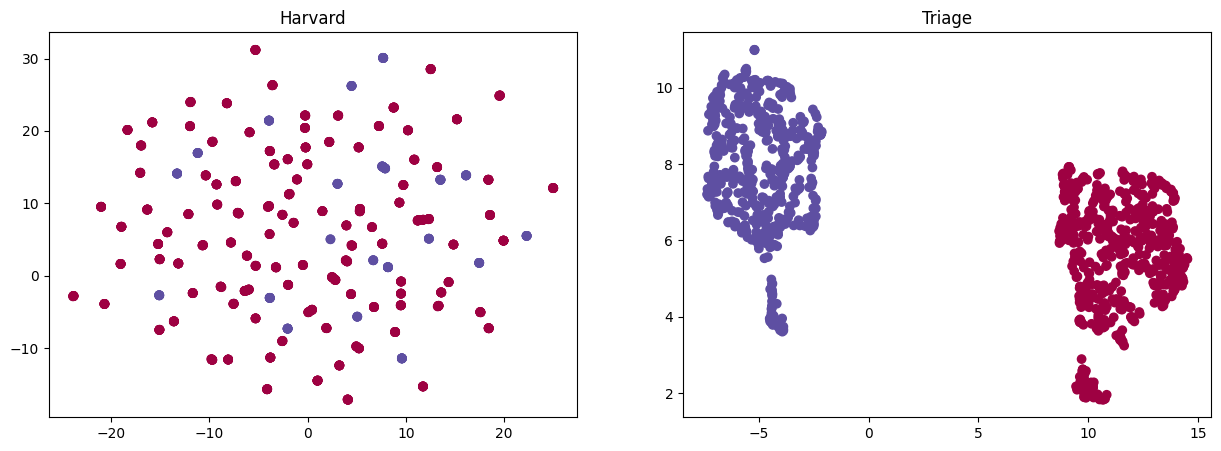

In [22]:
import umap
import matplotlib.pyplot as plt

X_harvard = df_harvard.drop(columns=['Exacerbation'])
X_harvard = X_harvard.fillna(X_harvard.median())
y_harvard = df_harvard['Exacerbation']
X_triage = df_triage.drop(columns=['Exacerbation'])
X_triage = X_triage.fillna(X_triage.median())
y_triage = df_triage['Exacerbation']

# create umap embeddings
umap_harvard = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_triage = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

X_harvard_umap = umap_harvard.fit_transform(X_harvard, y_harvard)
X_triage_umap = umap_triage.fit_transform(X_triage, y_triage)

# plot the embeddings
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(X_harvard_umap[:, 0], X_harvard_umap[:, 1], c=y_harvard, cmap='Spectral')
axs[0].set_title('Harvard')

axs[1].scatter(X_triage_umap[:, 0], X_triage_umap[:, 1], c=y_triage, cmap='Spectral')
axs[1].set_title('Triage')


In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

harvard_pca = df_harvard_fe.copy()
harvard_pca.dropna(subset=['Exacerbation'], inplace=True)
harvard_pca.fillna(harvard_pca.median(), inplace=True)
scaler = StandardScaler()
harvard_scaled = scaler.fit_transform(harvard_pca.drop(['Exacerbation'], axis=1))
pca_components = []
for i in range(0, len(harvard_scaled[0])):
    PCA(n_components=i)

# create explained variance plot
pca = PCA()
explained_variance = pca.fit(harvard_scaled).explained_variance_ratio_
cum_sum = np.cumsum(explained_variance)
# get all components

# calculate mutual information for each component
mutual_info = []
for i in range(0, len(explained_variance)):
    mutual_info.append(metrics.mutual_info_score(harvard_pca['Exacerbation'], pca.components_[i]))
print(explained_variance.shape)
plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
# plot mutual info per component
plt.bar(range(0,len(mutual_info)), mutual_info, alpha=0.5, align='center', label='Mutual information')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Explained variance using PCA on Harvard dataset")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


ValueError: Found input variables with inconsistent numbers of samples: [941, 103]

In [ ]:
import umap

# try 2D umap on harvard dataset
reducer = umap.UMAP()
embedding = reducer.fit_transform(harvard_scaled, )

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

triage_pca = df_triage_fe.copy()
triage_pca.dropna(subset=['Exacerbation'], inplace=True)
triage_pca.fillna(triage_pca.median(), inplace=True)
scaler = StandardScaler()
triage_pca = scaler.fit_transform(triage_pca.drop(['Exacerbation'], axis=1))
# create explained variance plot
pca = PCA()
explained_variance = pca.fit(triage_pca).explained_variance_ratio_
cum_sum = np.cumsum(explained_variance)
plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Explained variance using PCA on Triage dataset")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Variational Autoencoder

In [48]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn import preprocessing
DATA_PATH = './data/harvard_feature_engineered.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_data(path):
    # read in from csv, the header
    df = pd.read_csv(DATA_PATH, sep=';', decimal=',', header=0)
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, 1:]
    df_wine = df.iloc[:,0].values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # stadardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)    
    return x, standardizer, df_wine

def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=64,shuffle=True)
type(trainloader.dataset.x)

torch.Tensor

In [30]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [31]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD
    
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [33]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_mse = customLoss()

In [34]:
epochs = 1500
log_interval = 50
val_losses = []
train_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#        if batch_idx % log_interval == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * len(data), len(trainloader.dataset),
#                       100. * batch_idx / len(trainloader),
#                       loss.item() / len(data)))
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [35]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 45.8326
====> Epoch: 400 Average loss: 41.4494
====> Epoch: 600 Average loss: 37.7861
====> Epoch: 800 Average loss: 39.2427
====> Epoch: 1000 Average loss: 38.1423
====> Epoch: 1200 Average loss: 38.3367
====> Epoch: 1400 Average loss: 37.3795


In [37]:
# get embeddings:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        mu_tensor = mu   
        mu_output.append(mu_tensor)
        mu_result = torch.cat(mu_output, dim=0)

        logvar_tensor = logvar   
        logvar_output.append(logvar_tensor)
        logvar_result = torch.cat(logvar_output, dim=0)

NameError: name 'winetype' is not defined

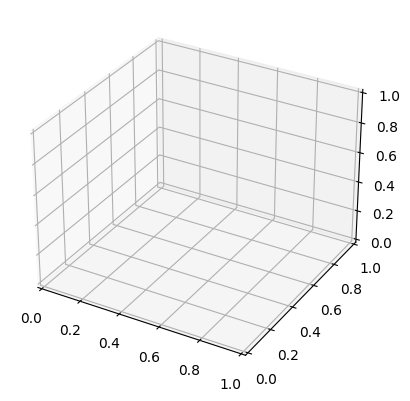

In [40]:
a